# GIS

1. http://overpass-turbo.eu/
1. https://www.openstreetmap.org/way/316971230#map=19/53.35026/-6.26077

In [3]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="IE"][admin_level=2];
(
    node[shop=supermarket](area);
);
out center;
"""

response = requests.get(overpass_url,
                       params={'data': overpass_query})

data = response.json()

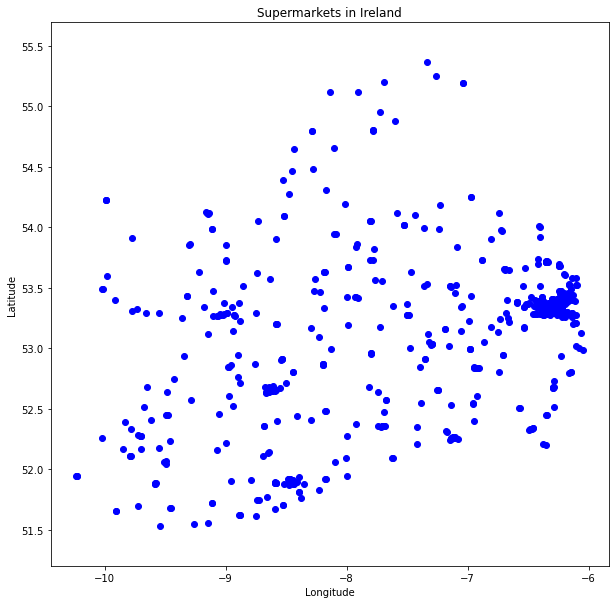

In [16]:
coords = []
for element in data['elements']:
    if element['type'] == 'node':
        lon = element['lon']
        lat = element['lat']
        coords.append((lon, lat))
        
x = np.array(coords)

plt.figure(figsize=(10, 10))
plt.plot(x[:, 0], x[:, 1], 'o', color='b')
plt.title('Supermarkets in Ireland')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()